# Some Basic Exploration...

In [1]:
import warnings
warnings.filterwarnings('ignore')

import cv2
import os
import gc
import h5py

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skimage.transform import probabilistic_hough_line

%matplotlib inline

In [2]:
try:
    del train_csv, depth_csv, comp_csv
    del img_train, img_test
    del trn_lines, tst_lines
    del trn_edges, tst_edges
    print 'Clearing memory...'
    gc.collect()
except:
    pass

## Number of Files in Each Folder:

In [3]:
# File paths
trn_path = '../data/train_images/'
msk_path = '../data/train_masks/'
tst_path = '../data/test_images/'
path_list = [trn_path, msk_path, tst_path]

In [4]:
# Number of files in each folder
file_lens = []
for path in path_list:
    print 'Looking at %s path:'%path
    file_lens.append(len(os.listdir(path)))
    print '%s files found!'%file_lens[-1]

Looking at ../data/train_images/ path:
4000 files found!
Looking at ../data/train_masks/ path:
4000 files found!
Looking at ../data/test_images/ path:
18000 files found!


## Printing Some Images in Each Folder:

Looking at ../data/train_images/:


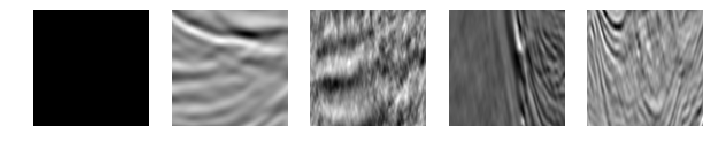

Looking at ../data/train_masks/:


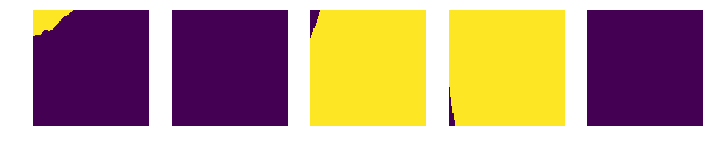

Looking at ../data/test_images/:


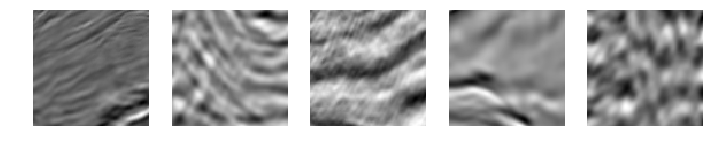

In [5]:
# Printing some images from each path
num_imgs = 5
num_rows = len(path_list)

for i, path in enumerate(path_list):
    print 'Looking at %s:'%path
    plt.figure(figsize=(12,10))
    for j in range(num_imgs):
        img_path = os.listdir(path)[np.random.randint(file_lens[i])]
        plt.subplot(1, num_imgs, (j+1))
        plt.imshow(plt.imread(path+img_path))
        plt.gca().axis('off')
    plt.show()

## Visualizations of Salt Distributions

In [6]:
# Image dimensions
w = 101
h = 101

# File paths
train_csv_path = '../data/train.csv'
depth_csv_path = '../data/depths.csv'

In [7]:
# Load csv files
train_csv = pd.read_csv(train_csv_path)
depth_csv = pd.read_csv(depth_csv_path)

# Join depth information with train csv
comp_csv = pd.merge(train_csv, depth_csv, on='id', how='left')

# Find number of salt pixels in train masks
def salt_counter(row):
    if len(row['rle_mask'])==1:
        return 0
    np_row = np.array(row['rle_mask'].split(), dtype=np.int32)
    return np_row.reshape(-1, 2)[:, 1].sum()

# Bin samples by category
def salt_binner(row):
    val = row['salt_ratio'] * 10
    if val == 0:
        return '0'
    elif val == 10:
        return '1.0'
    bot = np.floor(val)/10
    top = np.ceil(val)/10
    return '%s to %s'%(bot, top)

comp_csv['rle_mask'].replace(np.nan, '0', inplace=True)
comp_csv['salt_count'] = comp_csv.apply(salt_counter, axis=1)
comp_csv['salt_ratio'] = comp_csv['salt_count']/(w*h)
comp_csv['salt_label'] = comp_csv.apply(salt_binner, axis=1)

print 'Comp csv shape:', comp_csv.shape
comp_csv.head()

Comp csv shape: (4000, 6)


,id,rle_mask,z,salt_count,salt_ratio,salt_label
0,575d24d81d,0,843,0,0.000000,0
1,a266a2a9df,5051 5151,794,5151,0.504950,0.5 to 0.6
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,10133,0.993334,0.9 to 1.0
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,1522,0.149201,0.1 to 0.2
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,437,0.042839,0.0 to 0.1


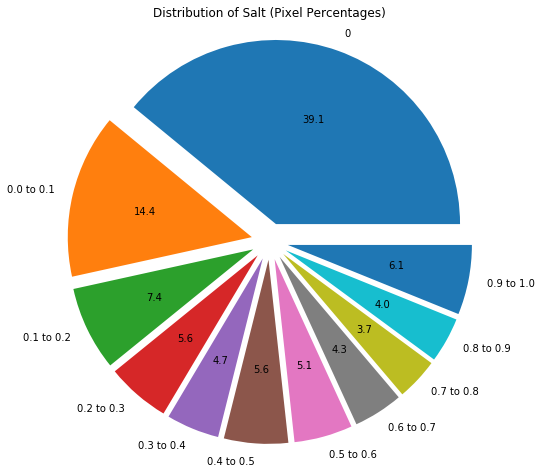

In [8]:
# Plot pie chart of distribution
bin_names, bin_counts = np.unique(comp_csv['salt_label'], return_counts=True)
explode = tuple(0.1 for i in range(len(bin_names)))

fig, axs = plt.subplots(figsize=(8, 8))
axs.pie(bin_counts, explode=explode, labels=bin_names, autopct='%.1f')
axs.axis('equal')
plt.title('Distribution of Salt (Pixel Percentages)')
plt.show()

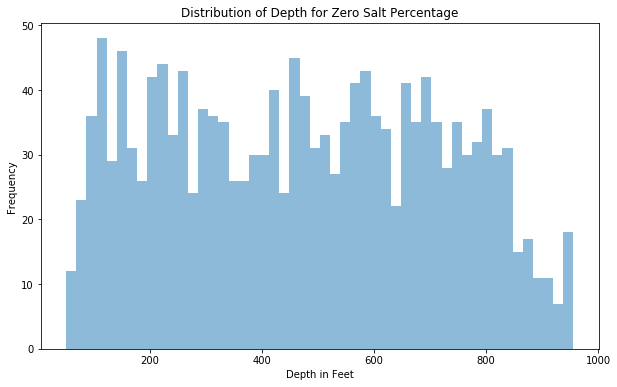

In [9]:
# Depth distributions for salt percentages
plt.figure(figsize=(10, 6))
comp_csv.loc[comp_csv['salt_label']=='0']['z'].plot.hist(bins=50, alpha=0.5)
plt.title('Distribution of Depth for Zero Salt Percentage')
plt.xlabel('Depth in Feet')
plt.show()

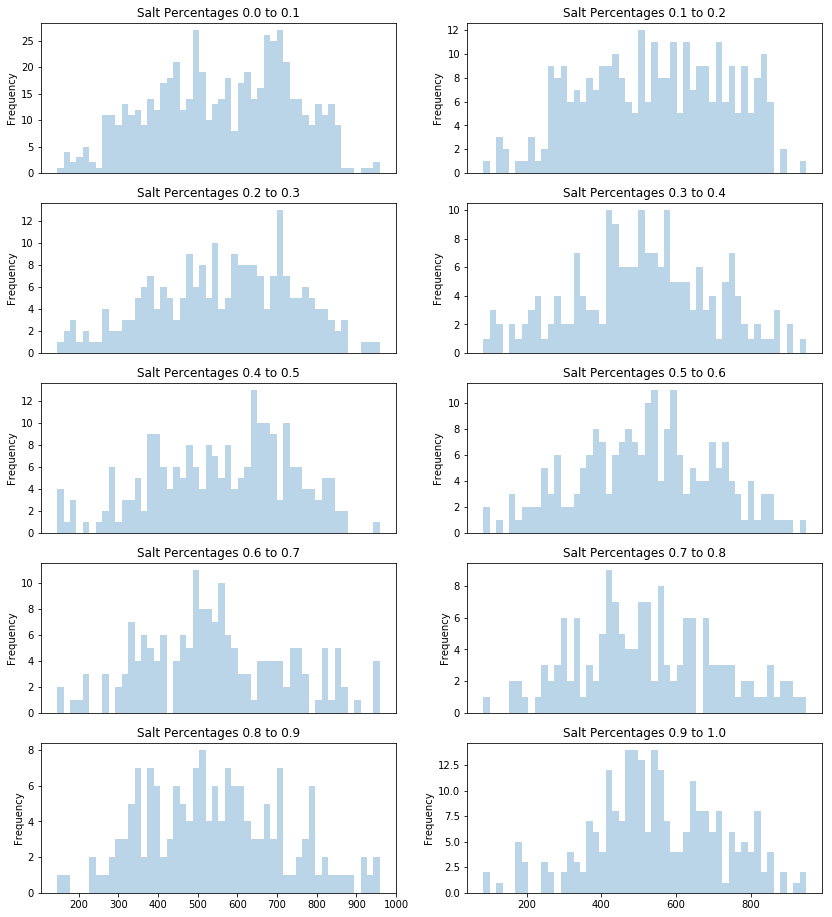

In [10]:
# Depth distribution for salt percentages
h_rows = 5
h_cols = 2
plt.figure(figsize=(14, 16))
for i, depth in enumerate(bin_names[1:]):
    plt.subplot(h_rows, h_cols, i+1)
    comp_csv.loc[comp_csv['salt_label']==depth]['z'].plot.hist(bins=50, alpha=0.3)
    plt.title('Salt Percentages %s'%depth)
    if i==8 or i==9:
        continue
    else:
        plt.xticks([])
plt.show()

## Train vs. Test Sets

In [11]:
def load_images(path):
    fnames = os.listdir(path)
    images = np.zeros((len(fnames), h, w))
    img_names = []
    for i, f in enumerate(fnames):
        images[i, :, :] = cv2.imread(path+f, 0)
        img_names.append(f.split('.')[0])
    return images, img_names

In [12]:
# Load images
img_train, trn_names = load_images(trn_path)
img_test, tst_names = load_images(tst_path)

img_train = img_train.astype(np.uint8)
img_test = img_test.astype(np.uint8)

# Flatten images
flat_trn = img_train.reshape((img_train.shape[0], h*w))
flat_tst = img_test.reshape((img_test.shape[0], h*w))

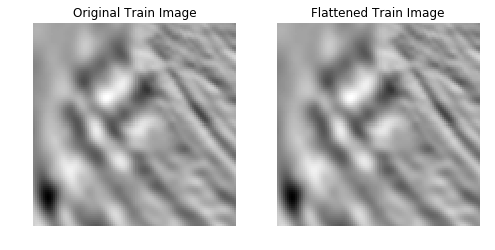

In [13]:
# Sanity check on flattened images
rand_idx = np.random.randint(img_train.shape[0])
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_train[rand_idx], cmap='gray')
plt.gca().axis('off')
plt.title('Original Train Image')
plt.subplot(1, 2, 2)
plt.imshow(flat_trn[rand_idx].reshape((h, w)), cmap='gray')
plt.gca().axis('off')
plt.title('Flattened Train Image')
plt.show()

In [14]:
# Calculate statistics
trn_means = np.mean(flat_trn, axis=1)
tst_means = np.mean(flat_tst, axis=1)

trn_std = np.std(flat_trn, axis=1)
tst_std = np.std(flat_tst, axis=1)

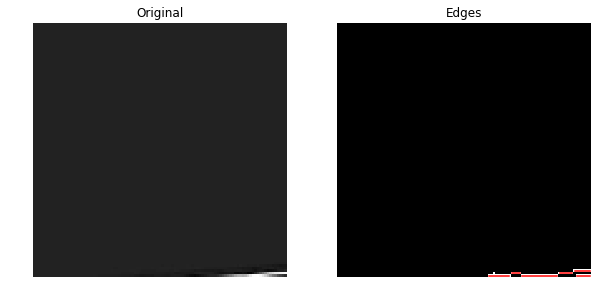

In [15]:
# Try out edge detection in openCV
rand_idx = np.random.randint(img_train.shape[0])
img = img_train[rand_idx]
edges = cv2.Canny(img, 1, 100, apertureSize=3)

lines = probabilistic_hough_line(edges, threshold=10, line_length=2, line_gap=0, seed=0)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap='gray')
ax[1].set_title('Edges')
ax[1].set_axis_off()

for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]), c='red')

In [16]:
# Apply Canny edge detection and probabilistic hough line transform
def save_as_h5py(fname, data):
    with h5py.File(fname, 'w') as handle:
        handle.create_dataset('data', data=data)
    return None

def load_h5py(fname):
    with h5py.File(fname, 'r') as handle:
        return handle['data'][:]

def canny_edges(data):
    d_edges = np.zeros_like(data)
    for i, img in enumerate(data):
        tmp_edge = cv2.Canny(img, 1, 100, apertureSize=3)
        d_edges[i, :, :] = tmp_edge
    return d_edges

def hough_lines(data):
    d_lines = []
    for edge in data:
        tmp_line = probabilistic_hough_line(edge, threshold=10, line_length=2, line_gap=0, seed=0)
        d_lines.append(np.array(tmp_line))
    return d_lines

exp_path = './exploration_data/'
trn_edge_name = 'trn_edges.h5'
tst_edge_name = 'tst_edges.h5'
explore_files = os.listdir(exp_path)

if trn_edge_name not in explore_files or tst_edge_name not in explore_files:
    print 'Generating edges...'
    trn_edges = canny_edges(img_train)
    tst_edges = canny_edges(img_test)
    print 'Saving edges...'
    save_as_h5py(exp_path+trn_edge_name, trn_edges)
    save_as_h5py(exp_path+tst_edge_name, tst_edges)
else:
    try:
        print 'Loading edges...'
        trn_edges = load_h5py(exp_path+trn_edge_name)
        tst_edges = load_h5py(exp_path+tst_edge_name)
    except:
        print 'Error encountered during load!'

print 'Generating lines using hough transform...'
trn_lines = hough_lines(trn_edges)
tst_lines = hough_lines(tst_edges)

Loading edges...
Generating lines using hough transform...


In [17]:
# Convert hough lines to statistics
line_counts_trn = [x.shape[0] for x in trn_lines]
line_counts_tst = [x.shape[0] for x in tst_lines]

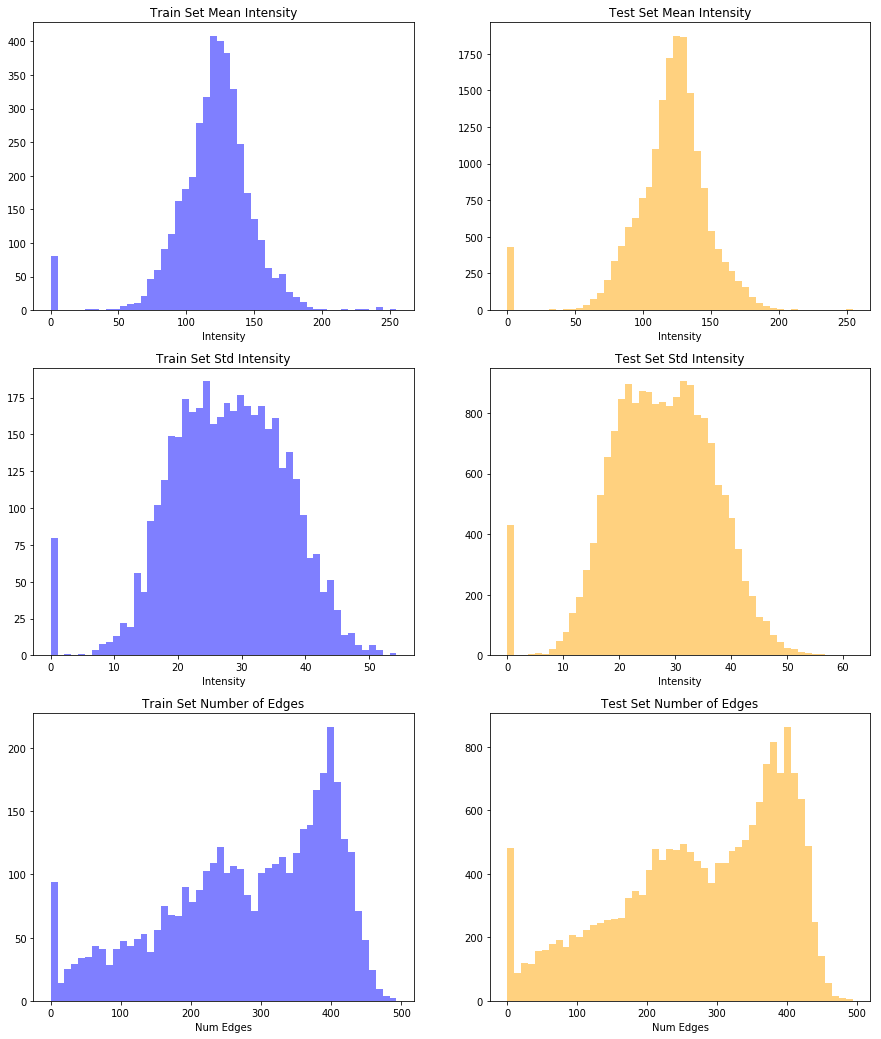

In [18]:
# Visualize statistics
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
ax = axes.ravel()

ax[0].hist(trn_means, bins=50, alpha=0.5, color='blue')
ax[0].set_title('Train Set Mean Intensity')
ax[0].set_xlabel('Intensity')

ax[1].hist(tst_means, bins=50, alpha=0.5, color='orange')
ax[1].set_title('Test Set Mean Intensity')
ax[1].set_xlabel('Intensity')

ax[2].hist(trn_std, bins=50, alpha=0.5, color='blue')
ax[2].set_title('Train Set Std Intensity')
ax[2].set_xlabel('Intensity')

ax[3].hist(tst_std, bins=50, alpha=0.5, color='orange')
ax[3].set_title('Test Set Std Intensity')
ax[3].set_xlabel('Intensity')

ax[4].hist(line_counts_trn, bins=50, alpha=0.5, color='blue')
ax[4].set_title('Train Set Number of Edges')
ax[4].set_xlabel('Num Edges')

ax[5].hist(line_counts_tst, bins=50, alpha=0.5, color='orange')
ax[5].set_title('Test Set Number of Edges')
ax[5].set_xlabel('Num Edges')

plt.show()

## Statistics for Training Set "Bins"

In [19]:
# Create statistics dataframe for train set
stats_dict = {'id': trn_names,
              'means': trn_means.tolist(),
              'std': trn_std.tolist(), 
              'edge_counts': line_counts_trn}
stats_df_train = pd.DataFrame.from_dict(stats_dict, orient='columns')

stats_df = pd.merge(comp_csv, stats_df_train, on='id', how='outer')
stats_df.head()

,id,rle_mask,z,salt_count,salt_ratio,salt_label,edge_counts,means,std
0,575d24d81d,0,843,0,0.000000,0,340,129.887364,31.135104
1,a266a2a9df,5051 5151,794,5151,0.504950,0.5 to 0.6,394,113.857171,35.468134
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,468,10133,0.993334,0.9 to 1.0,9,83.231546,9.849187
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,727,1522,0.149201,0.1 to 0.2,237,115.399667,37.366145
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,797,437,0.042839,0.0 to 0.1,221,127.167533,42.737262


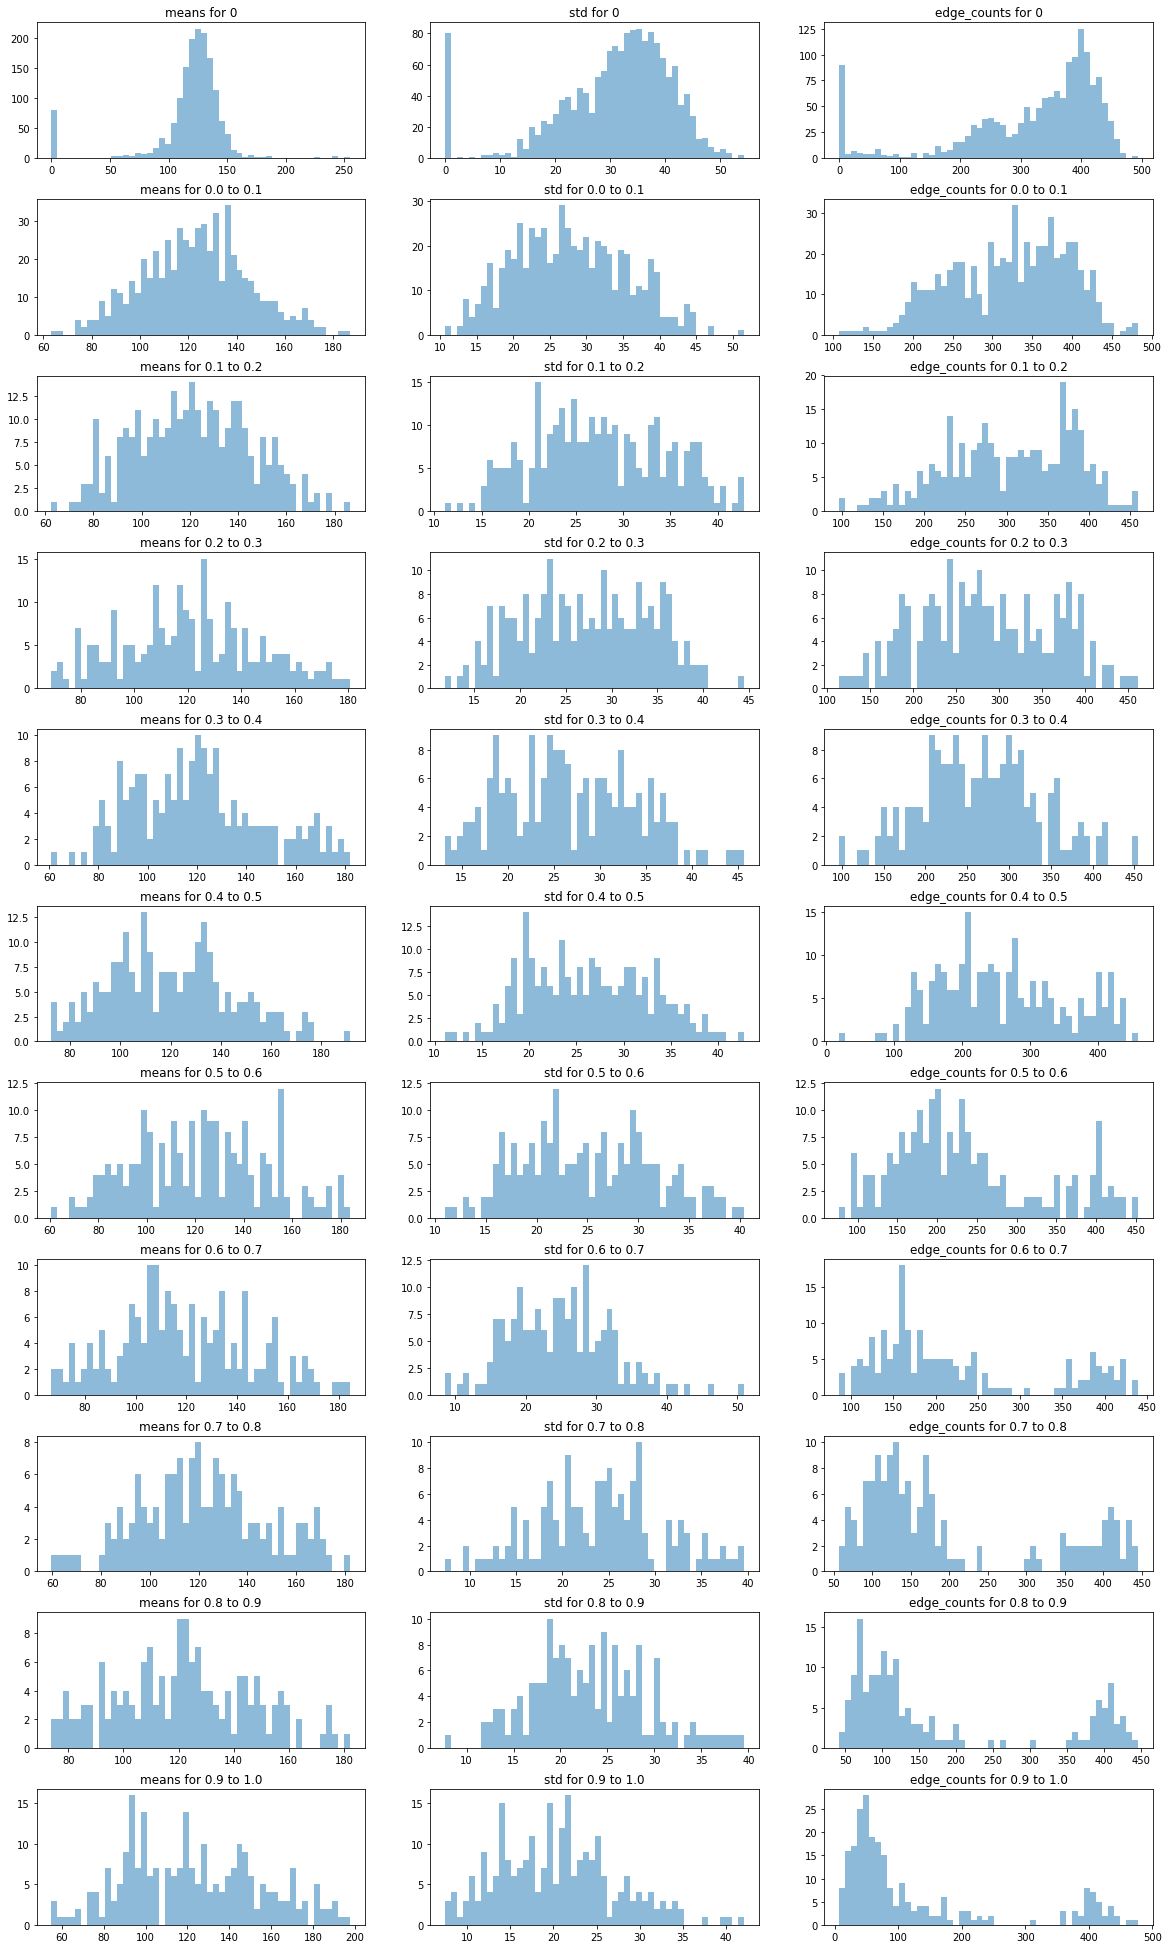

In [21]:
# Visualize by bins
plot_metrics = ['means', 'std', 'edge_counts']

fig, axes = plt.subplots(len(bin_names), len(plot_metrics), figsize=(20, 35))
ax = axes.ravel()
c = 0
for i, name in enumerate(bin_names):
    for j, metric in enumerate(plot_metrics):
        ax[c].hist(stats_df[stats_df['salt_label']==name][metric], bins=50, alpha=0.5)
        ax[c].set_title('%s for %s'%(metric, name))
        c += 1
plt.subplots_adjust(hspace=0.3)
plt.show()